In [1]:
import importlib

importlib.import_module("make_blocks")
from make_blocks import *

importlib.import_module("plotfun")
import warnings
warnings.filterwarnings('ignore')

importlib.import_module("get_all_fun_used")
from get_all_fun_used import *

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set_context('notebook')
#%config InlineBackend.figure_format = 'retina'

from operator import itemgetter, attrgetter
import os

os.chdir('/NS/social-net-blockchain/work/vpahari/block500/code/code/wfq_pickle_files')
import importlib

importlib.import_module("block")
from block import *

importlib.import_module("transaction")
from transaction import *

os.chdir('/NS/social-net-blockchain/work/vpahari/block500/code/code')

from plotfun import *
importlib.import_module("utils_plot")
from notebook_utils_plot import *


/home/vpahari/anaconda3/bin/python
/home/vpahari/anaconda3/bin/python
/home/vpahari/anaconda3/bin/python


# Background

The purpose of this notebook is to generate all figures relating to the dynamics of whether transactions will offer their fees as open or dark.

We started with empty MPO queues with equal hashrates. When a new transaction comes in with feerate X, it calculates if the expected waiting time of the transaction would be smaller if it offered its transaction as dark fee only to one MPO or as an open fee to every MPO.

We use a GPS approximation system in order to calculate the expected waiting time of a transaction. 

If a transaction is offered as dark to MPO M with hashrate h, then its expected waiting time is going to equal to the expected waiting time of the transaction above it plus (1 / h)

If a transaction is offered as open to all MPOs, then its expected waiting time is calculated as:
from t1 to t2 : h1 portion of the transaction goes through
from t2 to t3 : h1 + h2 portion of the transaction goes through

Continue until the entire transaction goes through. This is the approximation for the waiting time if the transaction is offered as open.

We assume that every transaction has size 1 and MPO produce blocks of size 1.

We kept adding new transactions into the system without removing them in order to see what transactions offer their fees as open vs dark, and in which situations they decide to do so.

Key findings:

1) When there is no congestion (queues are empty), transactions will offer their fees as open.

2) Once there is enough congestion, transactions will begin to offer their fees as dark.

3) When transactions begin to offer their fees as dark, new incoming transaction move very quickly from offering their fees as open to all the new transactions offering their fees as dark.

4) After a certain level of congestion, all incoming transactions offer their fees as dark





In [2]:
# With this library we import the functions we need for our GPS approximation system for expected waiting time
# This is used in order to decide if a transaction offering a feerate of X will offer its fees as open to one miner or dark to all miners

importlib.import_module("range_dark_fee_helper")
from range_dark_fee_helper import *

In [3]:
#Given a list of MPO queues, returns for which values the transaction offers its fee as open or dark
#The feerates go from 1 to max_feerate, with increments of diff at each time
def analyze_cutoff(MPO_list, max_feerate, diff):

    size_of_block = 1
    
    num_mpo = len(MPO_list)

    list_open_or_closed = []
    list_exp_open_closed = []
    list_only_open = []
    list_only_closed = []
    list_hidden_MPO = []
    
    open_block_list_big = []
    hidden_block_list_big = []

    for curr_feerate in range(1,max_feerate):
        
        feerate = 1 + (diff * (curr_feerate - 1))
        curr_tx = transaction(0, 1, feerate, 0, feerate)

        open_block_list, hidden_block_list = get_open_and_hidden_block_list_wfq(MPO_list, curr_tx, size_of_block)
        expected_finish_time_hidden, MPO_index_with_min = expected_wait_time_for_hidden_wfq(MPO_list, hidden_block_list)
        expected_finish_time_open, virtual_size_open = expected_wait_time_for_open_wfq(MPO_list, open_block_list)
        
        list_only_open.append(expected_finish_time_open)
        list_only_closed.append(expected_finish_time_hidden)
        open_block_list_big.append(open_block_list)
        hidden_block_list_big.append(hidden_block_list)

        if expected_finish_time_open <= expected_finish_time_hidden:
            list_open_or_closed.append(0)
            list_exp_open_closed.append(expected_finish_time_open)
            list_hidden_MPO.append(num_mpo)

        else:
            list_open_or_closed.append(1)
            list_exp_open_closed.append(expected_finish_time_hidden)
            list_hidden_MPO.append(MPO_index_with_min)
            
            
    return list_open_or_closed, list_exp_open_closed, list_only_open, list_only_closed, list_hidden_MPO, open_block_list_big, hidden_block_list_big


#Returns the feerate for which the fee is offered as open or dark
def get_hidden_axis_0_1(l, element, diff):
    
    prev = l[0]    
    x_axis = []
    
    for i in range(len(l)):
        if l[i] == element:
            x_axis.append(1 + round(i * diff, 4))
            
    return x_axis


#Returns the difference in the consecutive 
def consecutive(l, diff):
        
    if len(l) == 0:
        return []
    
    to_ret = [l[0]]
    
    for counter in range(len(l) - 1):
        
        if round(l[counter] + diff, 4) == l[counter + 1]:
            continue
            
        else:
            to_ret.append(l[counter])
            to_ret.append(l[counter+1])
            
    to_ret.append(l[-1])
    
    return to_ret
        

#Plot horizontal lines corresponding to the range of dark fees that would lead to the transaction offering its fees as dark 
def plot_horizontal_lines(MPO_to_use, init_savefig_name, numMPO, max_feerate, y_index, diff):
    
    list_open_or_closed_i, list_exp_open_closed_i, list_only_open_i, list_only_closed_i, list_hidden_MPO_i, open_block_list_big_i, hidden_block_list_big_i = analyze_cutoff(MPO_to_use, max_feerate, diff)
    x_axis_aa = get_hidden_axis_0_1(list_open_or_closed_i, 1, diff)
    cutoff_i = consecutive(x_axis_aa, diff)
    counter = 0
    
    if len(cutoff_i) == 0:
        return
        
    elif len(cutoff_i) == 1:
        plt.hlines(y = y_index, xmin=0, xmax=cutoff_i[0], color = '#377eb8', ls=':', linewidth=2)

    while counter < len(cutoff_i):
        plt.hlines(y = y_index, xmin=cutoff_i[counter], xmax=cutoff_i[counter + 1], color = '#377eb8',linewidth=2)
        counter += 2
        
#Plot horizontal lines for each state of the memepool queue.
#Each state corresponds to the number of transaction currently in the system.
def plot_horizontal_lines_with_blkround(full_list_i, init_str_to_use, nummpo, max_feerate,savefile_name, diff):
    format_list = ['.pdf']
    for curr_format in format_list:
        counter = 0
        fig, ax = plt.subplots()
        for blkrnd in full_list_i:
            #print(init_str_to_use + str(blkrnd))
            for pickle_name in glob.glob(init_str_to_use + str(blkrnd) + '.pickle'):
                with open(pickle_name, "rb") as openfile:
                    MPO_curr_i = pickle.load(openfile)
                #print(str(blkrnd))
                plot_horizontal_lines(MPO_curr_i, init_str_to_use + str(blkrnd), nummpo, max_feerate, blkrnd + 1, diff)

            counter += 1

        ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
        #plt.xlim(0,1000)
        plt.ylim(0,max(full_list_i) + 1)
        plt.ylabel('Number of txs')
        plt.xlabel('Range of fee for dark fee tx')
        savefile_name_new = savefile_name + curr_format
        plt.savefig(savefile_name_new, bbox_inches = 'tight')
        plt.show()
        plt.clf()
    
    
    
        


       



    

# Result

Figures below show the range for which transactions offer their fee as dark.

It supports our finding that transactions in the beginning of the simulation, when there is no congestion, offer their fees as open (to all MPOs).

Once the number of transaction increases, then transactions will begin to offer their fees as dark (to only one MPO). This is supported by the fact that as the number of transactions increases, the range of fees that would offer its fees as dark increases.

Feerates of the transactions are chosen from a Gausian Distribution of mean 100 and standard deviation of 30, and Exponential distribution of mean 1.



In [12]:
# The number of transactions in the system for plotting
i_list = [i + 1 for i in range(40)]

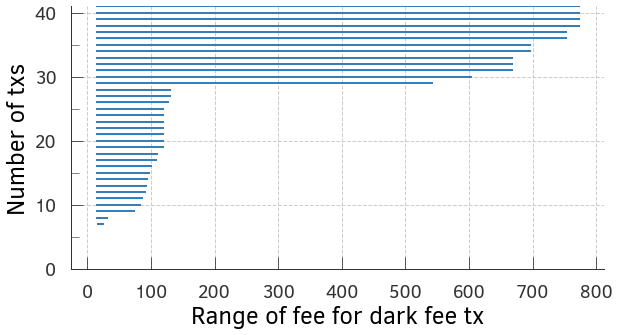

<Figure size 612x324 with 0 Axes>

In [5]:
type_now = "GAUSS"

str_init_7_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_7/between_7_wfq_0.14285714285714285_'+ type_now +'_blockround_'
savename_init_7_gauss_40 = 'wfq_pickle_files/figures_for_paper/range_dark_fee/horizontal_7_equal_0.1429_'+ type_now +'_40'

plot_horizontal_lines_with_blkround(i_list, str_init_7_gauss, 7, 2000, savename_init_7_gauss_40,1)

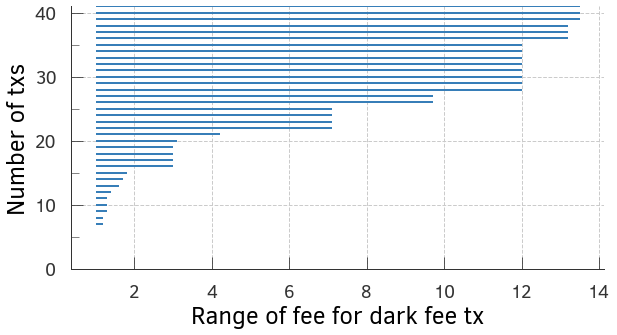

<Figure size 612x324 with 0 Axes>

In [6]:
type_now = "EXP"

str_init_7_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_7/between_7_wfq_0.14285714285714285_'+ type_now +'_blockround_'
savename_init_7_exp_40 = 'wfq_pickle_files/figures_for_paper/range_dark_fee/horizontal_7_equal_0.1429_'+ type_now +'_40'

plot_horizontal_lines_with_blkround(i_list, str_init_7_exp, 7, 2000, savename_init_7_exp_40,0.1)

# Transition from Open to Dark Txs

We see from the results above that as the number of transactions in the system increases, the range of fees that lead to a transaction offering their fee as dark to only one MPO increases. So, in the beginning all transactions offer their fees as open; however, after there is enough congestion, all transactions offer their fees as dark.

Here, we are trying to see here how fast the transition happens between transactions offering their fees as open to transactions offereing their fees as dark.



In [7]:
# Get the number of open transactions in the system
def get_num_open_txs(MPO_list):
    set_id = set()
    for MPO in MPO_list:
        for tx in MPO.MPO_hidden_queue.queue:
            if not tx.isOpen:
                set_id.add(tx.txid)
                
    return len(set_id)

# Plot of percentage of open transactions in the system
def plot_percentage_open(full_list_i, init_str_to_use, savefile_name):
    
    format_list = ['.pdf']
    
    for curr_format in format_list:
        counter = 0
        fig, ax = plt.subplots()
        num_open_list = []
        for blkrnd in full_list_i:
            for pickle_name in glob.glob(init_str_to_use + str(blkrnd) + '.pickle'):
                with open(pickle_name, "rb") as openfile:
                    MPO_curr_i = pickle.load(openfile)
                num_open = get_num_open_txs(MPO_curr_i)
                num_open_list.append(num_open / (blkrnd + 1))

        ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
        x_list = [i+1 for i in range(len(num_open_list))]
        plt.plot(x_list, num_open_list)
        #plt.xlim(-0.1, max(full_list_i))
        plt.ylim(0,1)
        plt.xlabel('Total Number of txs')
        plt.ylabel('Fraction of Dark Fee txs')
        savefile_name_new = savefile_name + curr_format
        plt.savefig(savefile_name_new, bbox_inches = 'tight')
        plt.show()
        plt.clf()      

In [13]:
# The number of transactions in the system for plotting
k_list = [i + 1 for i in range(100)]

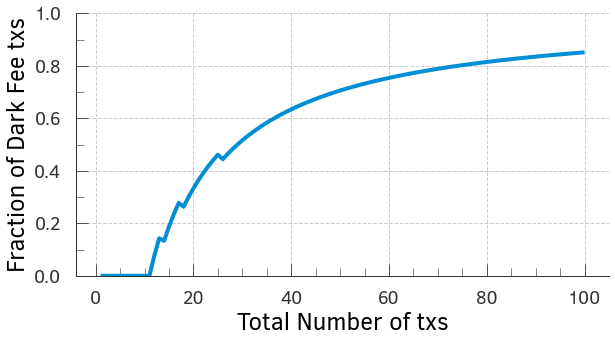

<Figure size 612x324 with 0 Axes>

In [14]:
type_now = "GAUSS"

str_equal_7_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_7/between_7_wfq_0.14285714285714285_'+ type_now +'_blockround_'
savename_equal_7_gauss = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_7_equal_0.1429_'+ type_now +'_100'

plot_percentage_open(k_list, str_equal_7_gauss,savename_equal_7_gauss)

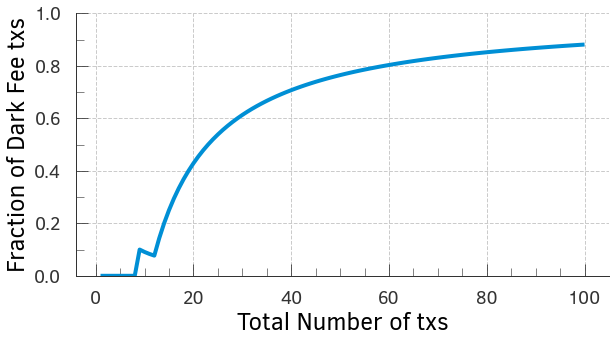

<Figure size 612x324 with 0 Axes>

In [15]:
type_now = "EXP"

str_equal_7_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_7/between_7_wfq_0.14285714285714285_'+ type_now +'_blockround_'
savename_equal_7_exp = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_7_equal_0.1429_'+ type_now +'_100'

plot_percentage_open(k_list, str_equal_7_exp,savename_equal_7_exp)

# Extra Figures for range of dark fee

Here we have extra figures for the range of dark fee transaction plots for both the Gaussian and Exponential Distributions



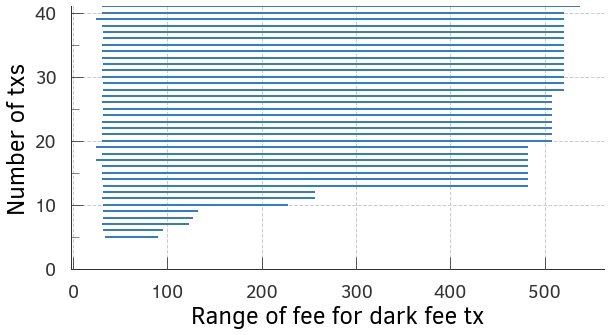

<Figure size 612x324 with 0 Axes>

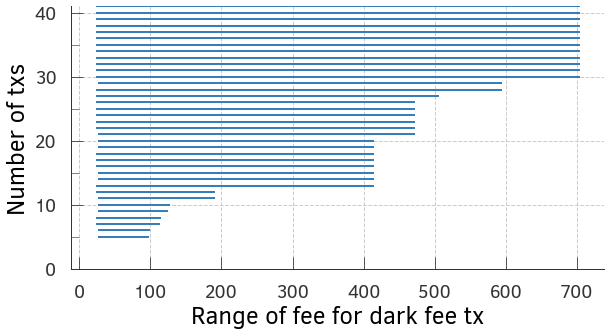

<Figure size 612x324 with 0 Axes>

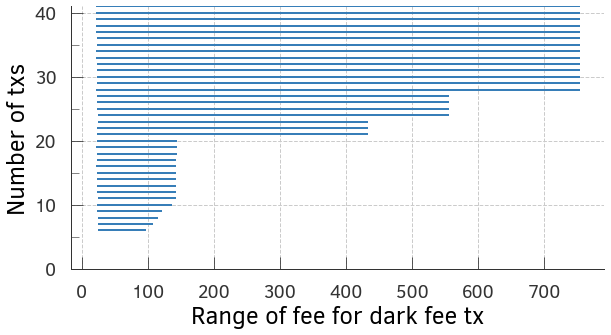

<Figure size 612x324 with 0 Axes>

In [17]:
type_now = "GAUSS"

str_init_4_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_4/between_4_wfq_0.25_'+ type_now +'_blockround_'
str_init_5_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_5/between_5_wfq_0.2_'+ type_now +'_blockround_'
str_init_6_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_6/between_6_wfq_0.16666666666666666_'+ type_now +'_blockround_'

savename_init_4_gauss_40 = 'wfq_pickle_files/figures_for_paper/range_dark_fee/horizontal_4_equal_0.25_'+ type_now +'_40'
savename_init_5_gauss_40 = 'wfq_pickle_files/figures_for_paper/range_dark_fee/horizontal_5_equal_0.2_'+ type_now +'_40'
savename_init_6_gauss_40 = 'wfq_pickle_files/figures_for_paper/range_dark_fee/horizontal_6_equal_0.1667_'+ type_now +'_40'

plot_horizontal_lines_with_blkround(i_list, str_init_4_gauss, 4, 2000, savename_init_4_gauss_40,1)
plot_horizontal_lines_with_blkround(i_list, str_init_5_gauss, 5, 2000, savename_init_4_gauss_40,1)
plot_horizontal_lines_with_blkround(i_list, str_init_6_gauss, 6, 2000, savename_init_4_gauss_40,1)

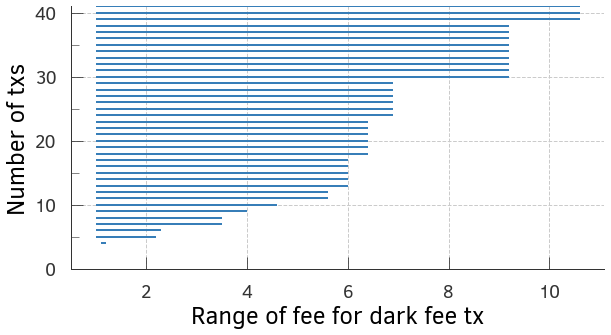

<Figure size 612x324 with 0 Axes>

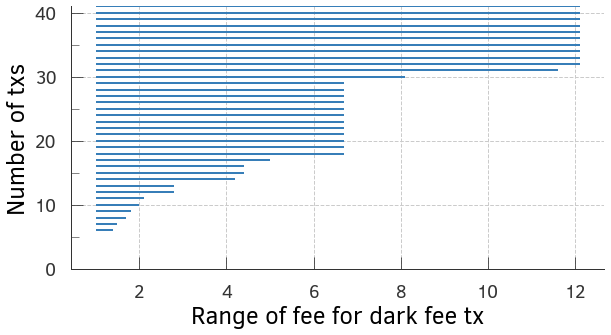

<Figure size 612x324 with 0 Axes>

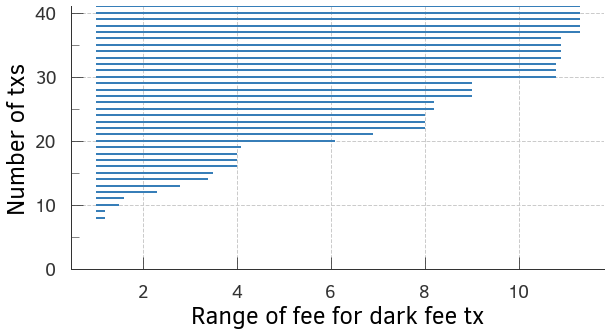

<Figure size 612x324 with 0 Axes>

In [19]:
type_now = "EXP"

str_init_4_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_4/between_4_wfq_0.25_'+ type_now +'_blockround_'
str_init_5_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_5/between_5_wfq_0.2_'+ type_now +'_blockround_'
str_init_6_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_6/between_6_wfq_0.16666666666666666_'+ type_now +'_blockround_'

savename_init_4_exp_40 = 'init_sim/new_pickle_file_init/final_figs/horizontal_4_equal_0.25_'+ type_now +'_40'
savename_init_5_exp_40 = 'init_sim/new_pickle_file_init/final_figs/horizontal_5_equal_0.2_'+ type_now +'_40'
savename_init_6_exp_40 = 'init_sim/new_pickle_file_init/final_figs/horizontal_6_equal_0.1667_'+ type_now +'_40'

plot_horizontal_lines_with_blkround(i_list, str_init_4_exp, 4, 2000, savename_init_4_exp_40,0.1)
plot_horizontal_lines_with_blkround(i_list, str_init_5_exp, 5, 2000, savename_init_5_exp_40,0.1)
plot_horizontal_lines_with_blkround(i_list, str_init_6_exp, 6, 2000, savename_init_6_exp_40,0.1)

# Extra Figures for transition between Open and Dark Txs

Here we have extra figures for the transition between open and dark txs in our simulations.



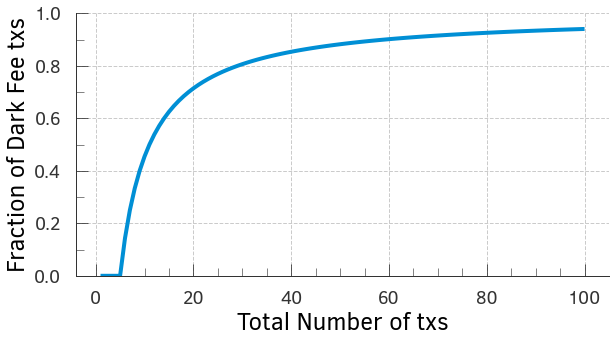

<Figure size 612x324 with 0 Axes>

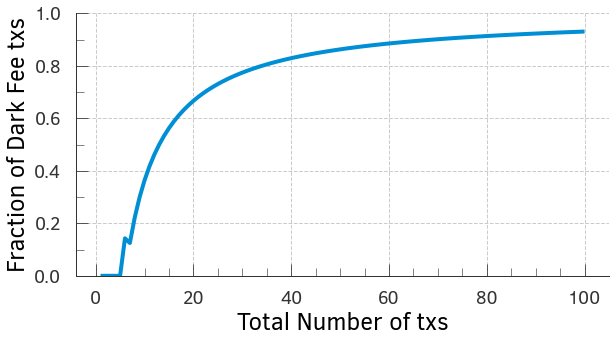

<Figure size 612x324 with 0 Axes>

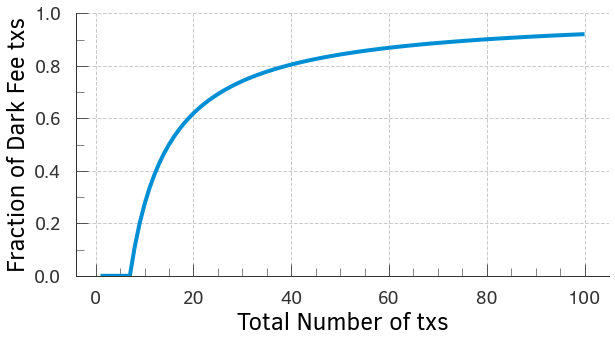

<Figure size 612x324 with 0 Axes>

In [35]:
type_now = "GAUSS"

str_equal_4_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_4/between_4_wfq_0.25_'+ type_now +'_blockround_'
str_equal_5_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_5/between_5_wfq_0.2_'+ type_now +'_blockround_'
str_equal_6_gauss = 'init_sim/new_pickle_file_init/equal_hash/MPO_6/between_6_wfq_0.16666666666666666_'+ type_now +'_blockround_'

savename_equal_4_gauss = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_4_equal_0.25_'+ type_now +'_100'
savename_equal_5_gauss = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_5_equal_0.2_'+ type_now +'_100'
savename_equal_6_gauss = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_6_equal_0.1667_'+ type_now +'_100'

plot_percentage_open(k_list, str_equal_4_gauss, savename_equal_4_gauss)
plot_percentage_open(k_list, str_equal_5_gauss, savename_equal_5_gauss)
plot_percentage_open(k_list, str_equal_6_gauss, savename_equal_6_gauss)

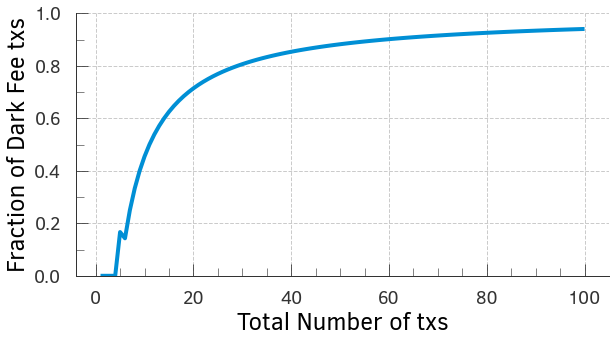

<Figure size 612x324 with 0 Axes>

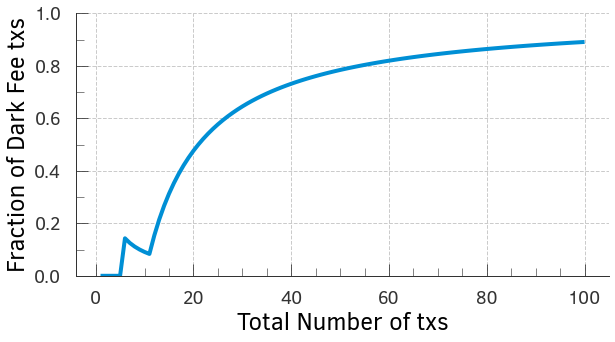

<Figure size 612x324 with 0 Axes>

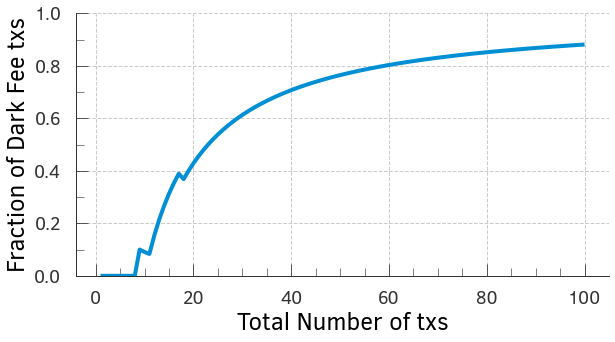

<Figure size 612x324 with 0 Axes>

In [33]:
type_now = "EXP"

str_equal_4_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_4/between_4_wfq_0.25_'+ type_now +'_blockround_'
str_equal_5_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_5/between_5_wfq_0.2_'+ type_now +'_blockround_'
str_equal_6_exp = 'init_sim/new_pickle_file_init/equal_hash/MPO_6/between_6_wfq_0.16666666666666666_'+ type_now +'_blockround_'

savename_equal_4_exp = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_4_equal_0.25_'+ type_now +'_100'
savename_equal_5_exp = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_5_equal_0.2_'+ type_now +'_100'
savename_equal_6_exp = 'wfq_pickle_files/figures_for_paper/range_dark_fee/frac_dark_txs_6_equal_0.1667_'+ type_now +'_100'

plot_percentage_open(k_list, str_equal_4_exp,savename_equal_4_exp)
plot_percentage_open(k_list, str_equal_5_exp,savename_equal_5_exp)
plot_percentage_open(k_list, str_equal_6_exp,savename_equal_6_exp)